# How to use the PTA Optimal Statistic

Author: Kyle Gersbach

In this tutorial we will cover the basics of how to use the Optimal Statistic as a parameter estimator and as a detection statistic. 

## Outline

As a warmup:
1. Construct a Hellings and Downs curve

Main objectives:
1. Construct a the CURN PTA object (Done in the previous tutorial)
2. Sample the PTA object (Done in the previous tutorial)
    1. Load the La_forge Core
3. Construct an Optimal Statistic object
4. Run the maximum-likelihood Optimal Statistic
    1. Construct a binned separation vs correlation plot
    2. Use pair covariance to better estimate the amplitude
5. Run the Noise Marginalized Optimal Statistic 
    1. Create histogram of SNR
    2. Create histogram of full $A^2$ distribution


### Imports!

In [1]:
# Increase the resolution of your plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Autoreload is handy if the functions within the imports change between runs. 
# Helpful for development!
%load_ext autoreload
%autoreload 2

# Nice to have imports
import numpy as np
from matplotlib import pyplot as plt
import pickle
from scipy.stats import norm

# Imports for PTA modeling
import enterprise
from enterprise_extensions import models 
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions import blocks

# La_forge for loading in chains!
from la_forge.core import Core

# The actual optimal statistic
from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic

# New functions I made for you!
from pair_covariance import pair_covariant_OS, pair_covariant_NMOS
from os_utils import binned_pair_correlations, binned_pair_covariant_correlations
from os_utils import uncertainty_sample


## Warmup: Creating a Hellings and Downs curve

It will be very handy to create your own HD curve, for both this notebook and for future reference. The first task is to create a function which accepts a parameter 'xi' which is a pulsar pair separation angle (in radians) and returns the ORF for that separation. The HD curve is defined as

$$
\Gamma_{ab} = \frac{1}{2} - \frac{1-\cos{\xi_{ab}}}{4} \left[ \frac{1}{2} - 3 \ln \left( \frac{1-\cos{\xi_{ab}}}{2} \right) \right],
$$

where $\xi_{ab}$ is the pulsar pair separation in radians between pulsar a and b. Note that the valid range for this version of the HD is $(0,\pi]$. Technically the HD with 0 separation is a pulsar with itself (which is defined), but since the OS only looks at cross-correlations, this case never comes up and you won't need to implement that.

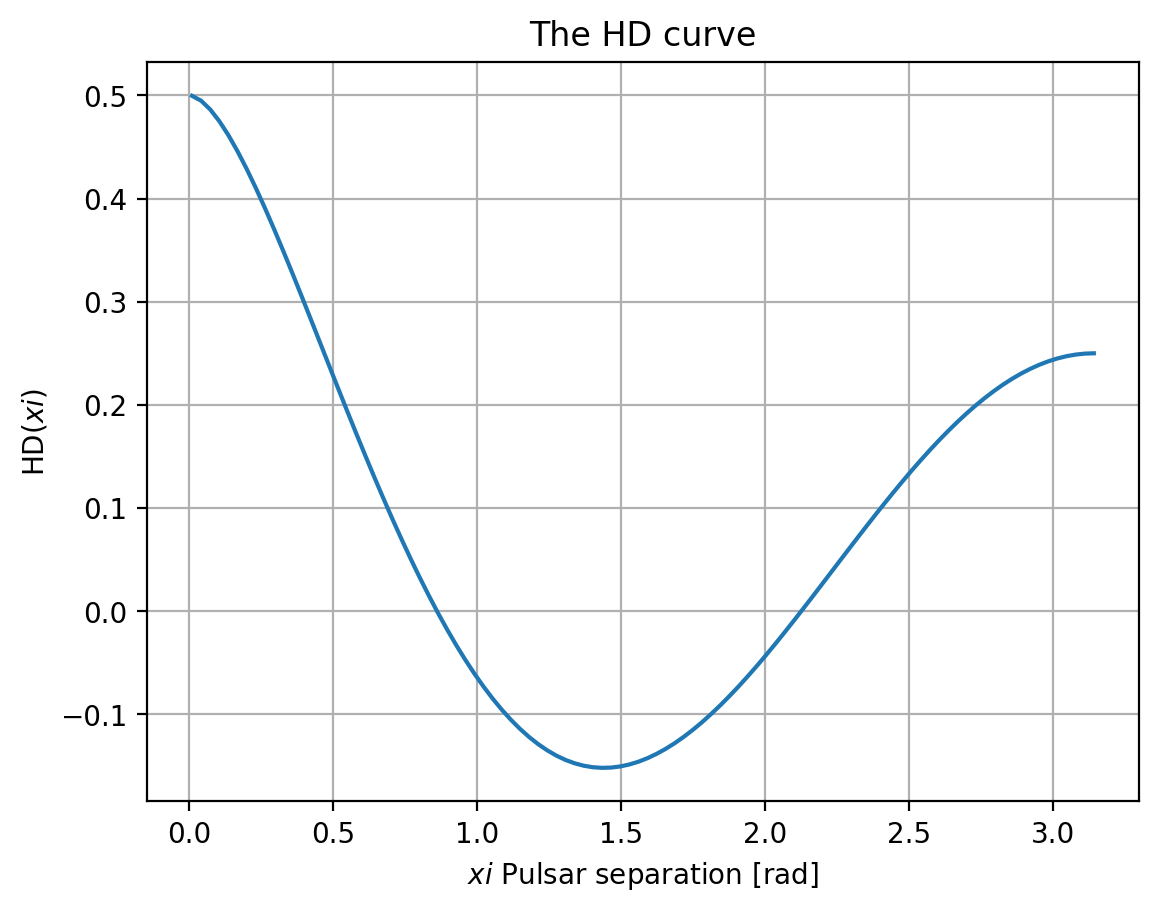

In [2]:

def HD_curve(xi):
    c = (1-np.cos(xi))/2
    return (1/2) - (c/2)*( (1/2) - 3*np.log(c) )



# Lets test it!
xi_range = np.linspace(0.01,np.pi,100)
# My function supports vectorization!
HD_curve = HD_curve(xi_range)

plt.plot(xi_range,HD_curve)
plt.xlabel('$xi$ Pulsar separation [rad]')
plt.ylabel('HD($xi$)')
plt.title('The HD curve')
plt.grid()
plt.show()

## Construct the PTA object

We need to construct a PTA object for the optimal statistic since it needs to use many matrix products that the PTA can make for us! To do this, we will need to load in the pulsar list, then construct the PTA object, exactly like you did in the previous tutorials!


In [3]:
# Lets load up the pulsars
with open('data/sim_ng_psrs.pkl','rb') as f:
    psrs = pickle.load(f)
 

# Since this is a simulated dataset, I happen to know the injected amplitude!
true_amplitude = 6e-15

In [4]:
# Now lets construct the PTA. We already did this in the last tutorial!

Tspan = get_tspan(psrs)

efac = models.parameter.Constant(1.0)
equad = models.parameter.Constant(-np.inf) # Basically having no equad
ef = models.white_signals.MeasurementNoise(efac=efac,log10_t2equad=equad)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=5, # Number of GWB frequencies to analyze
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

irn = blocks.red_noise_block(Tspan=Tspan,components=5) # Number of IRN frequencies to model

# Importantly, the OS only works with a non-marginalized timing model!
tm = models.gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn + irn

pta = models.signal_base.PTA([model(psr) for psr in psrs])

## Sampling the PTA

With our PTA constructed we need to get samples from a Common Uncorrelated Red Noise (CURN) search. While I show how you might construct and run your sampler, we've included a la_forge core for you so we can skip to using the OS.

In [7]:
to_sample = False

if to_sample:
    # Sample the PTA
    # We can use a fancy sampler setup from enterprise extensions!
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'sim_ng_CURN/'

    # Setup_sampler will add some extra jump proposals to make things easier
    sampler = setup_sampler(pta,chain_loc,resume=True,human='KAG')

    # We need an initial sample
    x0 = np.hstack([p.sample() for p in pta.params])

    # Sample the posterior. Need to make sure you have converged before using in
    # the OS.
    sampler.sample(x0, Niter=int(1e6))

    # With things sampled, we need to grab the chain itself.
    # We can use la_forge to simplify things!
    lfcore = Core(chaindir=chain_loc)
    
    lfcore.save('data/sim_ng_CURN.core')

else:
    # No need to sample, instead, we can just grab our pre-made la_forge core!

    lfcore = Core(corepath='data/sim_ng_CURN.core')


## Construct an Optimal Statistic object

Constructing the Optimal Statistic object is actually REALLY easy, but there are many things that you can change. The important parameters for instancing the OptimalStatistic are:

- psrs
    - The list of Enterprise.Pulsar for the PTA (Needs to be the same order as the PTA construction)
- pta
    - The PTA object to grab matrix products from. Needs to be constructed exactly as was done for the CURN sampling. Technically optional, but you should ALWAYS include this. The default PTA can mis-model!
- gamma_common
    - The spectral index of the GWB power law. Set to None if you have a varried gamma CURN
- orf 
    - The overlap reduction function to use. Defaults to Hellings and Downs (HD).
- noisedict
    - The white noise dictionary of the PTA. This needs to be the same noise dictionary used in the CURN sampling!

Let us construct the OS object using a $13/3$ spectral index powerlaw and using an HD correlation pattern

In [8]:
# Construct the OS object

OS_obj = OptimalStatistic(psrs, gamma_common=13./3., orf='hd', pta=pta)

## Run the maximum-likelihood Optimal Statistic

The most basic form of the OS uses the maximum likelihood parameter vector. This is trivial when using la_forge as it will tell us all we need!

In [9]:
# Lets print out all of our parameters
print(lfcore.params)

# That's a lot of parameters... (2*45 intrinsic pulsar parameters + 1 GWB parameter)
# (this will also print some handy things at the end!)

# Next, we need to get the likelihood chain. We can get this through index searching!
like_idx = lfcore.params.index('lnlike')

# Now, grab the full likelihood chain (after removing the burn in)
# chain will have shape (# of mcmc iterations X # of parameters + diagnostic chains)
ln_chain = lfcore.chain[lfcore.burn:, like_idx]

# Now that we have that, we need find the index of the highest likelihood
max_like_idx = np.argmax(ln_chain)

# Now grab the parameter vector (don't forget to burn the chain!)
max_like_vector = lfcore.chain[lfcore.burn + max_like_idx, :]

# But these are just numbers. The OS wants a dictionary, so lets construct that dictionary
max_like_dictionary = {name:value for name,value in zip(lfcore.params, max_like_vector)}

print(max_like_dictionary)

['B1855+09_red_noise_gamma', 'B1855+09_red_noise_log10_A', 'B1937+21_red_noise_gamma', 'B1937+21_red_noise_log10_A', 'B1953+29_red_noise_gamma', 'B1953+29_red_noise_log10_A', 'J0023+0923_red_noise_gamma', 'J0023+0923_red_noise_log10_A', 'J0030+0451_red_noise_gamma', 'J0030+0451_red_noise_log10_A', 'J0340+4130_red_noise_gamma', 'J0340+4130_red_noise_log10_A', 'J0613-0200_red_noise_gamma', 'J0613-0200_red_noise_log10_A', 'J0636+5128_red_noise_gamma', 'J0636+5128_red_noise_log10_A', 'J0645+5158_red_noise_gamma', 'J0645+5158_red_noise_log10_A', 'J0740+6620_red_noise_gamma', 'J0740+6620_red_noise_log10_A', 'J0931-1902_red_noise_gamma', 'J0931-1902_red_noise_log10_A', 'J1012+5307_red_noise_gamma', 'J1012+5307_red_noise_log10_A', 'J1024-0719_red_noise_gamma', 'J1024-0719_red_noise_log10_A', 'J1125+7819_red_noise_gamma', 'J1125+7819_red_noise_log10_A', 'J1453+1902_red_noise_gamma', 'J1453+1902_red_noise_log10_A', 'J1455-3330_red_noise_gamma', 'J1455-3330_red_noise_log10_A', 'J1600-3053_red_noi

Now that we have the maximum likelihood value, lets run the optimal statistic!

Upon giving the OS the parameter dictionary, the OS will return:
- xi
    - The vector of pulsar pair separations
- rho
    - The vector of $\rho_{ab}$ correlated powers
- sig
    - The vector of $1-\sigma$ standard deviation in $\rho_{ab}$
- A2
    - The mean $\hat{A}^2$ of the Gaussian fit on the GWB amplitude square
- A2s
    - The $1-\sigma$ standard deviation of the $\hat{A}^2$ mean.

In [10]:
xi,rho,sig,A2,A2s = OS_obj.compute_os(max_like_dictionary)

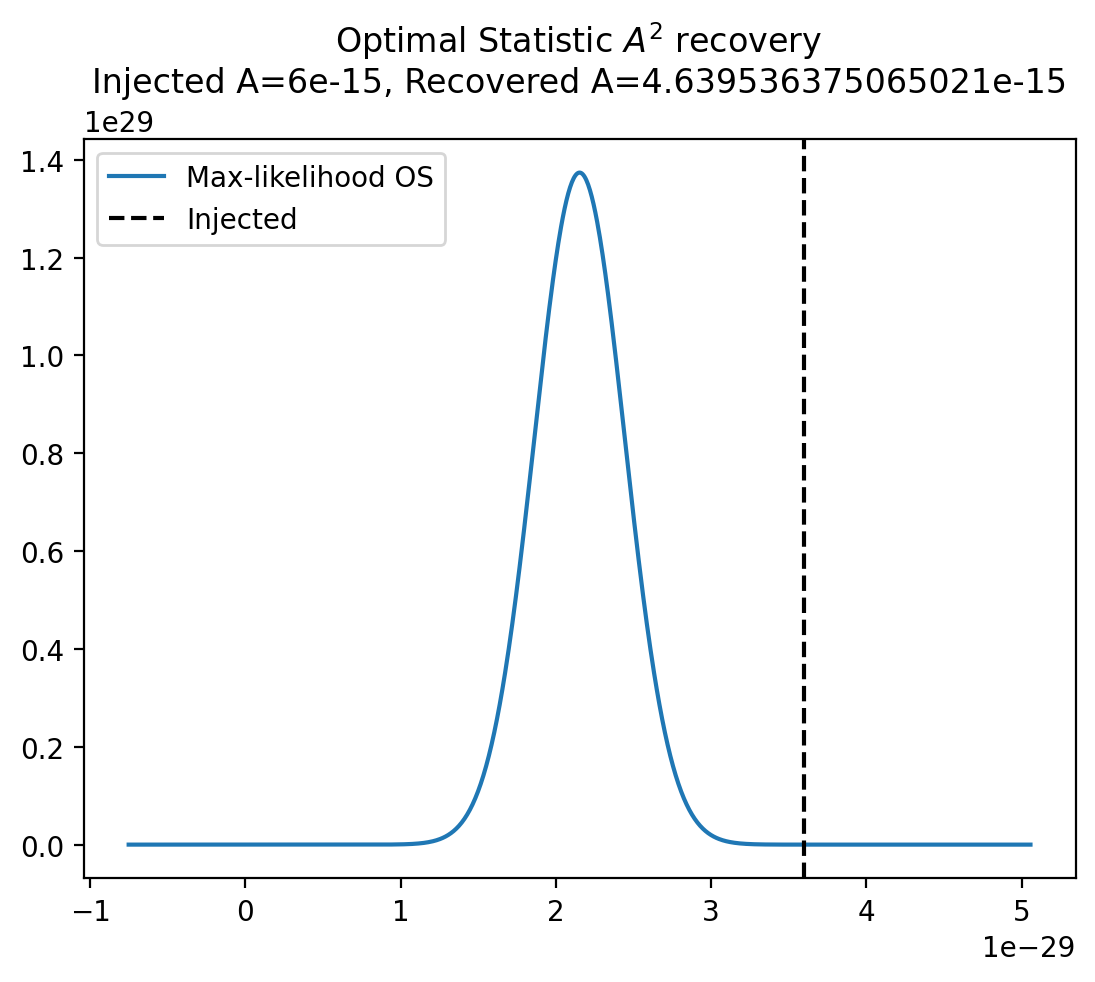

In [11]:
# Now lets plot the fit. Since we use a Gaussian fit, we can express it as such!
max_fit = norm(loc=A2,scale=A2s)

# Define a range of amplitude (squared) values to span (lets look at 5-sigma)
A2_range = np.linspace(A2-10*A2s,A2+10*A2s,1000)

plt.plot(A2_range,max_fit.pdf(A2_range),label=f'Max-likelihood OS')
plt.axvline(true_amplitude**2,linestyle='dashed',color='k',label='Injected')
plt.title(f'Optimal Statistic $A^2$ recovery \nInjected A={true_amplitude}, Recovered A={np.sqrt(A2)}')
plt.legend()
plt.show()


### What is the OS fitting?

It might be hard to tell what exactly the OS doing. When I say it is a Gaussian fit, what exactly does that mean? Well, lets make a handy visualization plot.

The OS fits an amplitude modulated HD curve to the correlated powers. So lets plot the correlated powers as a function of the pulsar separations

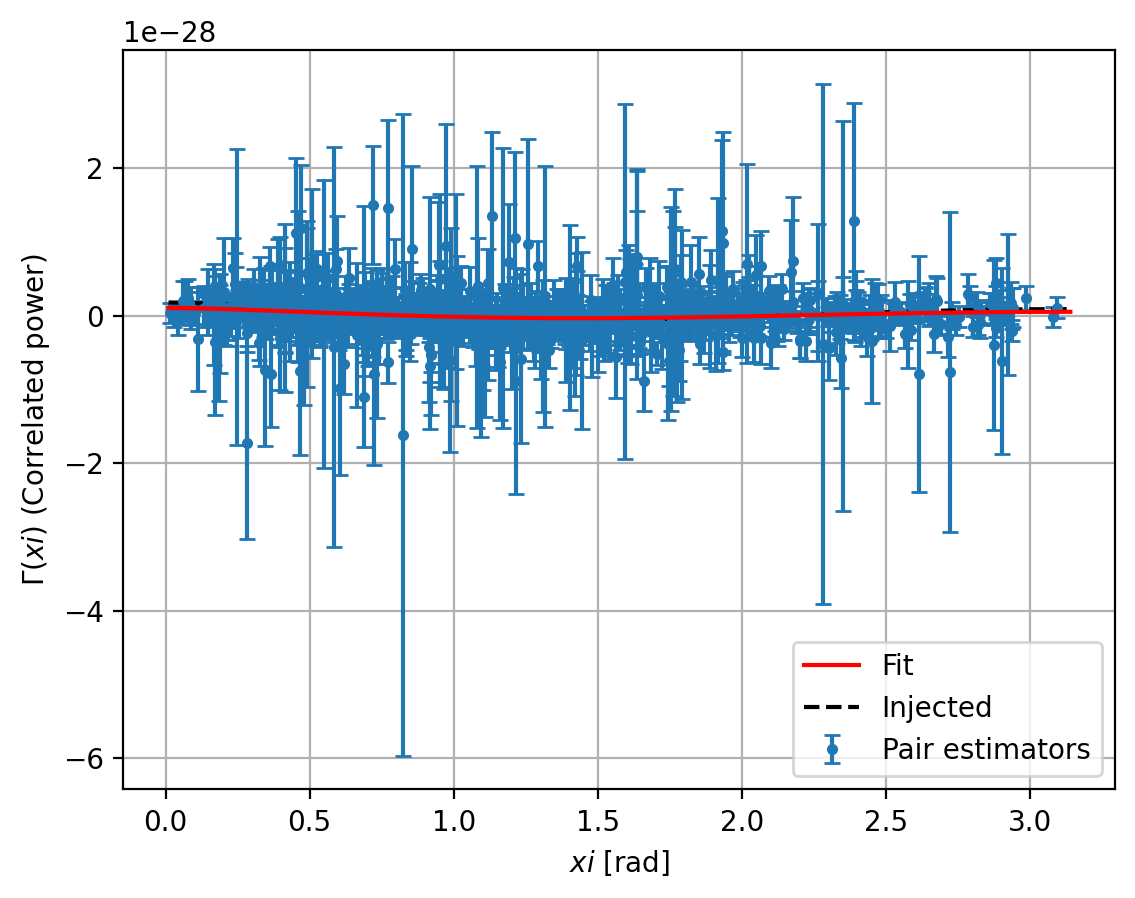

In [12]:
# Plot the pair correlated powers!
plt.errorbar(x=xi, y=rho, yerr=sig, fmt='.', capsize=3,label='Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (A2-A2s)*HD_curve, (A2+A2s)*HD_curve,color='r',alpha=0.2,zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

That's pretty hard to see. Lots of datapoints, and big error bars. We can bin our estimators together. This binned correlation plot is the more common thing to show (Also included in the NG 15yr GWB evidence paper!)

You can check how the code works in the os_utils.py file, however, the gist is that we just take a weighted mean of the $\rho_{ab}$ corresponding to each bin. We try to keep the number of pairs in each bin the same as to make the final error bars similar. 

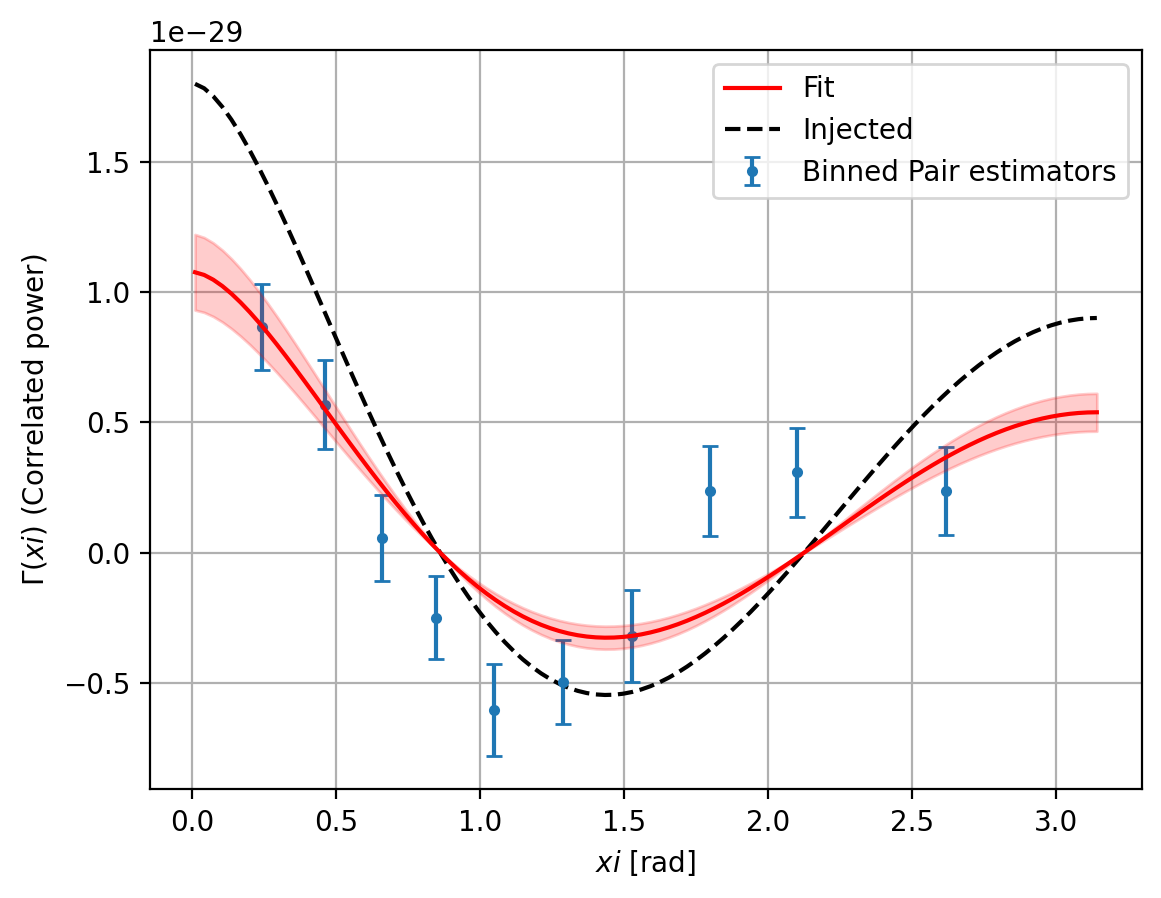

In [13]:
# Get the binned representation
xi_bin, rho_bin, sig_bin = binned_pair_correlations(xi, rho, sig, bins=10)

# Plot the pair correlated powers!
plt.errorbar(x=xi_bin, y=rho_bin, yerr=sig_bin, fmt='.', capsize=3,label='Binned Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (A2-A2s)*HD_curve, (A2+A2s)*HD_curve,color='r',alpha=0.2,zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

As a final test, lets print out the SNR and the Z-score of the injected value in our estimator. The Z-score is effectively how many sigma away the injected is from the recovered values.

In [14]:
# Lets also print out the SNR
print(f'Max likelihood OS SNR =',A2/A2s)

# And also the Z score (i.e. number of sigma the recovery is from the injection)
print(f'Max likelihood OS Z-score =',np.abs(A2-true_amplitude**2)/A2s)

Max likelihood OS SNR = 7.412457481387222
Max likelihood OS Z-score = 4.984512451963831


How is the fit? Did it work? If you have a high Z-score, maybe not so much...

Why doesn't the OS work in this case? The hint is the SNR. Our SNR is quite high, suggesting that we may be in the strong-signal regime! As I alluded in the presentation, the strong-signal regime breaks some of the assumptions to the Optimal Statistic as it was originally formulated (Sometimes called the 'traditional' optimal statistic). To combat this, we can employ the recently developed pair covariance code!

Pair covariance is a way to encorporate covariance between the different pairs. Why do we need this? Think about this:

I have 3 pulsars A, B, and C. Pulsar A is at some point in the sky, and pulsar B and C are somewhere else in the sky, but the separation between B and C is very small (i.e. $\xi_{ab} \approx \xi_{ac} >> \xi_{bc}$). In this case, pair AB and AC are effectively measuring the same space of the GWB! The two pairs are not independent! With that said, pair covariance is computationally expensive as there are $(N_{pairs} \times N_{pairs}) / 2$ elements within the covariance matrix! 

Luckily, I'm a software engineer and I made my code real fast! :)

This pair_covariant_OS() function contains my implementation of the pair covariant Optimal Statistic. This function is a preview for a more comprehensive OS package I'm currently developing.

Unlike the traditional OS, the pair covariant OS swaps out the array of 1-sigma uncertainties on $\rho_{ab}$ (sig) with a covariance matrix between all pairs (C). Note that the dimensions of C are $(N_{pairs} \times N_{pairs})$


In [15]:
# This function takes in an OptimalStatistic object and a dictionary of parameter 
# vectors to calculate the OS
xi,rho,C,pc_A2,pc_A2s = pair_covariant_OS(OS_obj,max_like_dictionary)


Lets run through the same processes as we did with the traditional OS

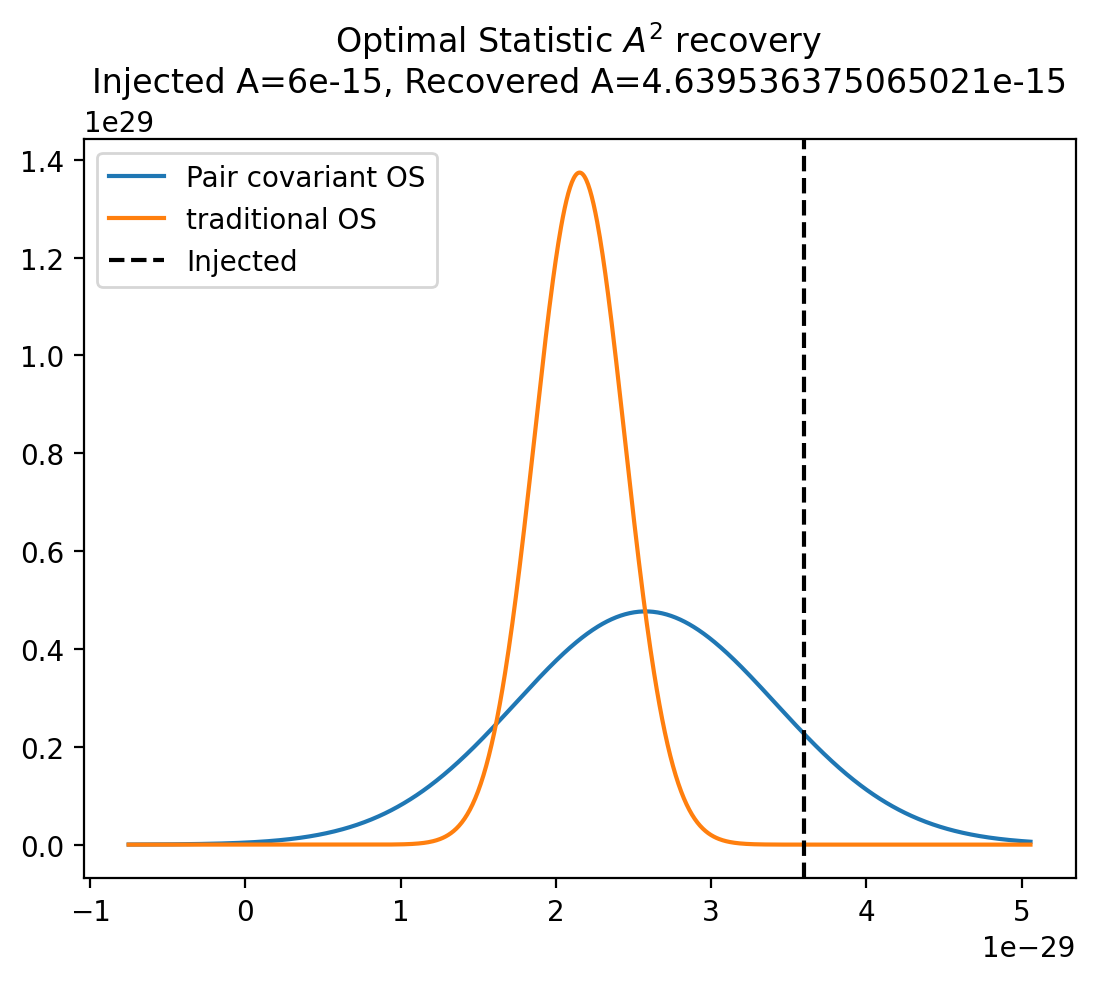

In [16]:
# Now lets plot the fit. Since we use a Gaussian fit, we can express it as such!
pc_max_fit = norm(loc=pc_A2,scale=pc_A2s)

plt.plot(A2_range,pc_max_fit.pdf(A2_range),label=f'Pair covariant OS')

plt.plot(A2_range,max_fit.pdf(A2_range),label=f'traditional OS')
plt.axvline(true_amplitude**2,linestyle='dashed',color='k',label='Injected')
plt.title(f'Optimal Statistic $A^2$ recovery \nInjected A={true_amplitude}, Recovered A={np.sqrt(A2)}')
plt.legend()
plt.show()


Now plot the binned correlated power!

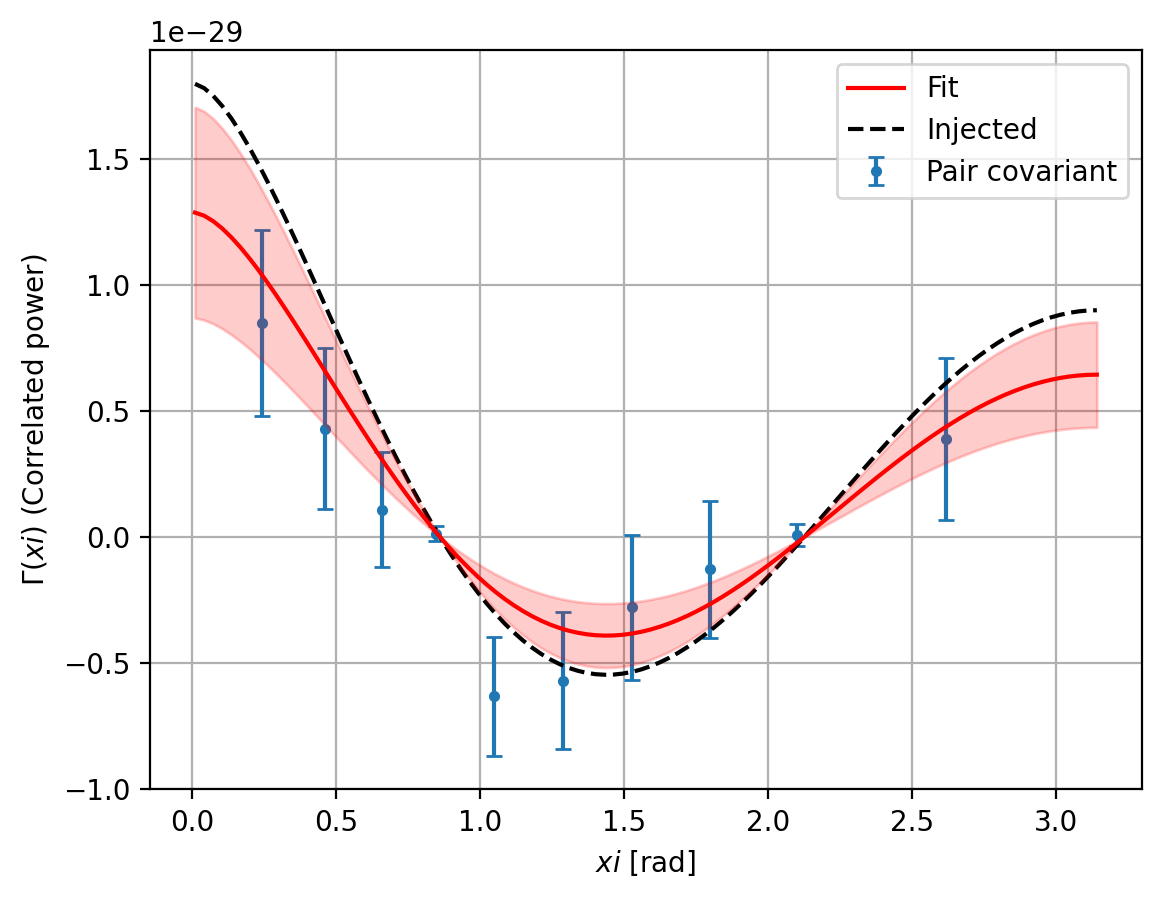

In [17]:
# Get the binned representation (Ask me why I need the orf here!)
pc_xi_bin, pc_rho_bin, pc_sig_bin = binned_pair_covariant_correlations(xi, rho, C, bins=10, orf='hd')

# Plot the pair correlated powers!
plt.errorbar(x=pc_xi_bin, y=pc_rho_bin, yerr=pc_sig_bin, fmt='.', capsize=3, label='Pair covariant')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, pc_A2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (pc_A2-pc_A2s)*HD_curve, (pc_A2+pc_A2s)*HD_curve,color='r',alpha=0.2,zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Lets also print out the SNR
print(f'Pair covariant OS SNR =',pc_A2/pc_A2s) # This is not a great estimator (Ask me why!)

# And also the Z score (i.e. number of sigma the recovery is from the injection)
print(f'Pair covariant OS Z-score =',np.abs(pc_A2-true_amplitude**2)/pc_A2s)

Pair covariant OS SNR = 3.07960737695892
Pair covariant OS Z-score = 1.222303261986348


It may not be clear that pair covariance is better, as the SNR can be drastically lower. However, we find that pair covariance is far less biased than the traditional in all regimes!

Here's a P-P plot for proof (More diagonal is better!)[[Gersbach et al 2024](https://arxiv.org/pdf/2406.11954)]

![image](data/Images/OS_v_PCOS_1e-14_V.png)

## Noise marginalization

As was mentioned in the presentation, the choice of the maximum-likelihood value for the parameter vector is, well, unoptimal. In reality, intrinsic red noise parameters can vary wildly between samples and can play a large role in noise-dominated regimes. To help combat the effects of this, the Noise Marginalized Optimal Statistic (NMOS) was developed.

The NMOS marginalizes over the different noise parameters within the PTA. This is done by selection many random parameter vectors from the MCMC chain and running each through the OS. There are some caveats to be aware of though. The biggest being that we now have distributions of $\hat{A}^2$ rather than single numbers.

Running the NMOS is quite simple. We just need to give the OS the chain of parameters to use!

In [19]:
os_chain = lfcore.chain[:-4] # We need to cut off the diagnostic chains (i.e. likelihood, posterior, etc.)
# You can check which parameters are diagnostics by inspecting lfcore.params

os_chain_names = lfcore.params[:-4]

# The number of noise draws N is generally going to be between 1-10 thousand
# the goal is to have a stable distribution! (ask me what it means to be stable)
# this function doesn't have a progress bar, so it may take some time!
xi,nm_rho,nm_sig,nm_A2,nm_SNR = OS_obj.compute_noise_marginalized_os(os_chain,os_chain_names,
                                                                     N=1000)

# This cell took about a minute for me

For whatever reason, the NMOS returns SNRs instead of sigma values, so lets get the sigma values back

$$ \sigma_{A^2} = \frac{\sigma_{A^2}}{\hat{A}^2} \times \hat{A}^2 = SNR^{-1} \times \hat{A}^2$$

In [20]:
nm_A2s = nm_A2/nm_SNR

Now lets plot the SNR distribution

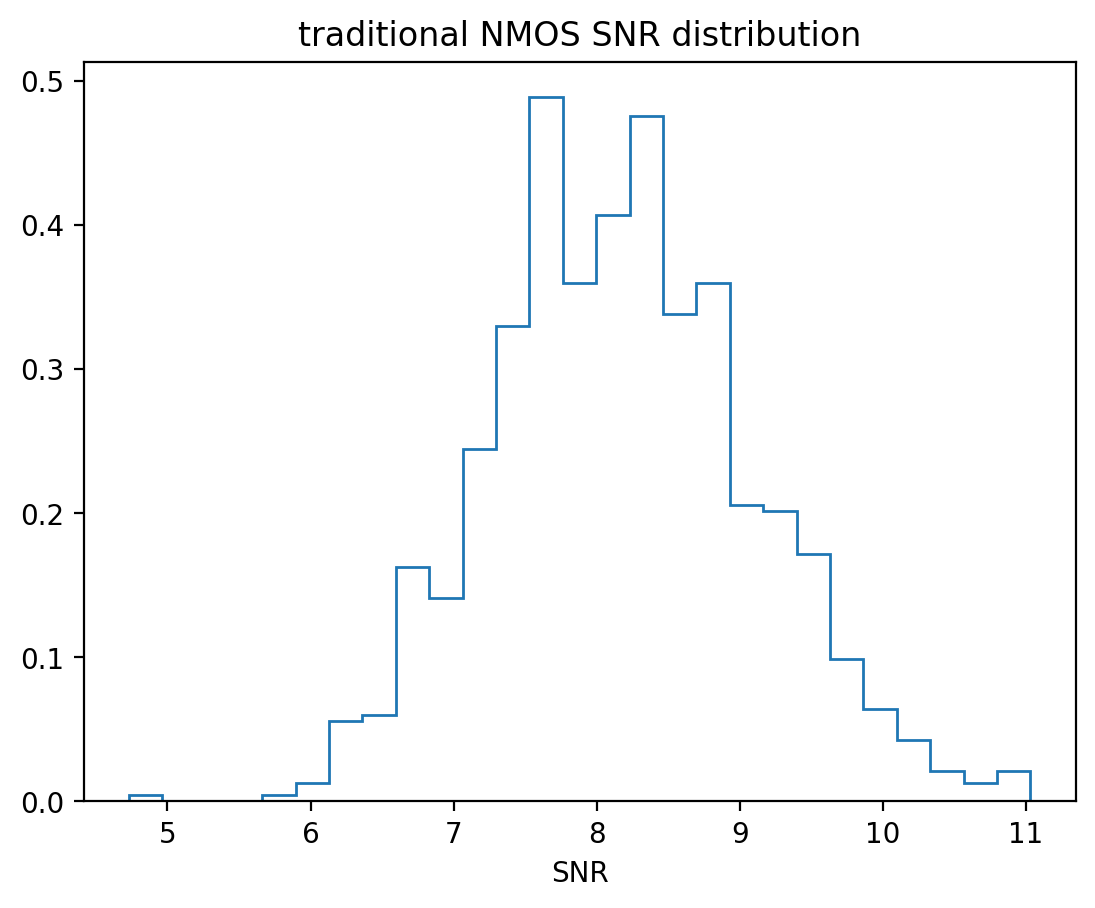

In [21]:
plt.hist(nm_SNR,bins='auto',histtype='step',density=True)
plt.xlabel('SNR')
plt.title('traditional NMOS SNR distribution')
plt.show()

### Important: About plotting the amplitude distribution

Something important to know (because many people miss this nuance) is that the distibution on $\hat{A}^2$ is NOT the total distribution on the amplitude square. See the little hat? That indicates that a **mean**, leading to the distribution on $\hat{A}^2$ being a distribution of mean estimators NOT the distribution on the amplitude square. If you want the true distribution of the amplitudes, you should convert each Gaussian mean to a full Gaussian using [**uncertainty sampling**](https://arxiv.org/abs/2406.11954). This technique is akin to a kernel density estimator where the width of the Gaussian kernel is determined by the uncertainty in the estimator.

Included in the os_utils.py file is the code to compute said uncertainty sampling

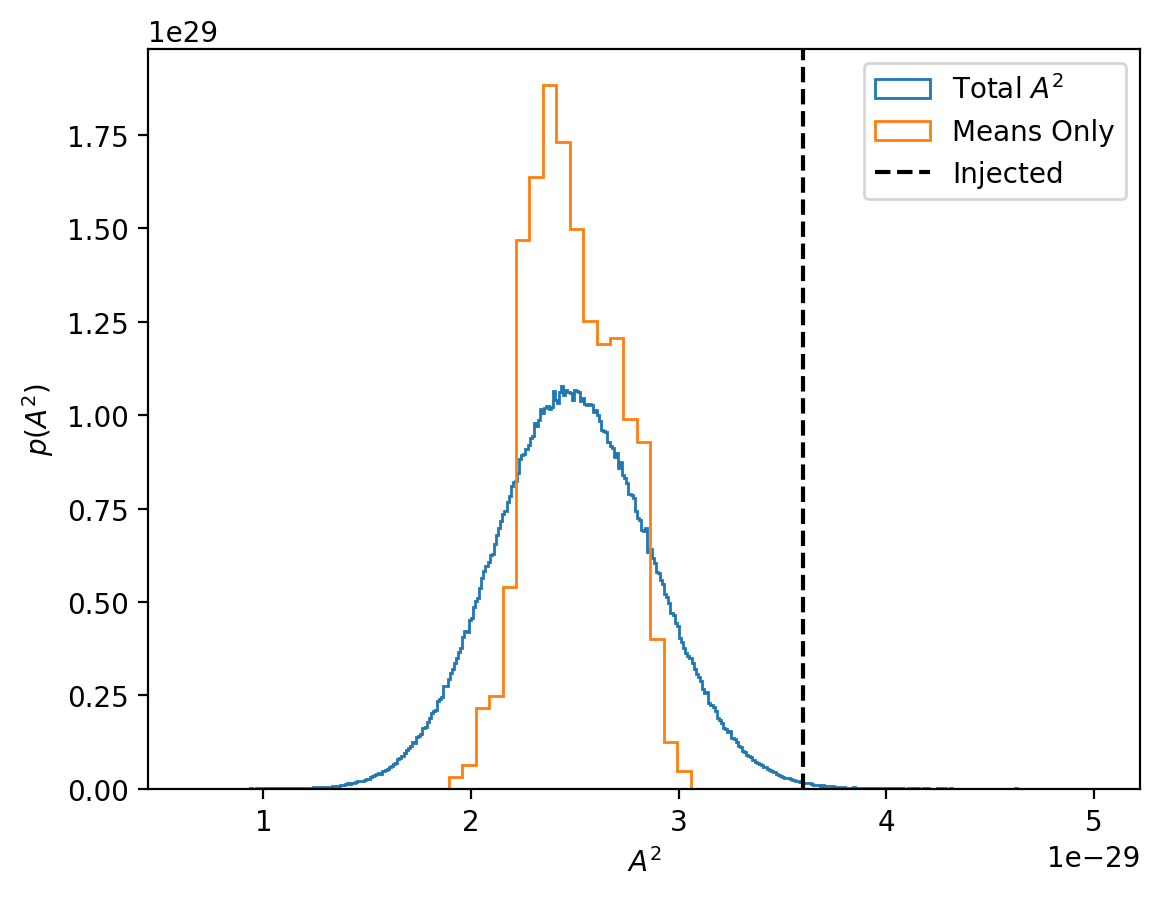

In [22]:
total_a2 = uncertainty_sample(nm_A2,nm_A2s)

# Now plot the total distribution
plt.hist(total_a2,bins='auto',histtype='step',density=True,label='Total $A^2$')

# Compare it to just the means
plt.hist(nm_A2,bins='auto',histtype='step',density=True,label='Means Only')


plt.axvline(true_amplitude**2,linestyle='dashed',color='k',label='Injected')
plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.legend()
plt.show()

Notice how the mean only distribution is far more sharply peaked and the tails are far less populated? That is very common and often much worse in real datasets. If you ever plan to use the NMOS for parameter estimation, use uncertainty sampling!

### Pair covariant NMOS

As with the traditional OS, pair covariance can also be applied to the NMOS. This process takes substantially longer to compute than the traditional NMOS, but it is far better at parameter estimation. 

Keep in mind that PC-NMOS isn't great for SNR calculations as the noise term contains an assumed GWB!

Since the PC-NMOS takes a long time, I'll just show it briefly with 100 NMOS samples

In [23]:
pc_nm_A2, pc_nm_A2s = pair_covariant_NMOS(OS_obj, os_chain, os_chain_names ,Niter=100)

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


And, like before, lets plot it with uncertainty sampling!

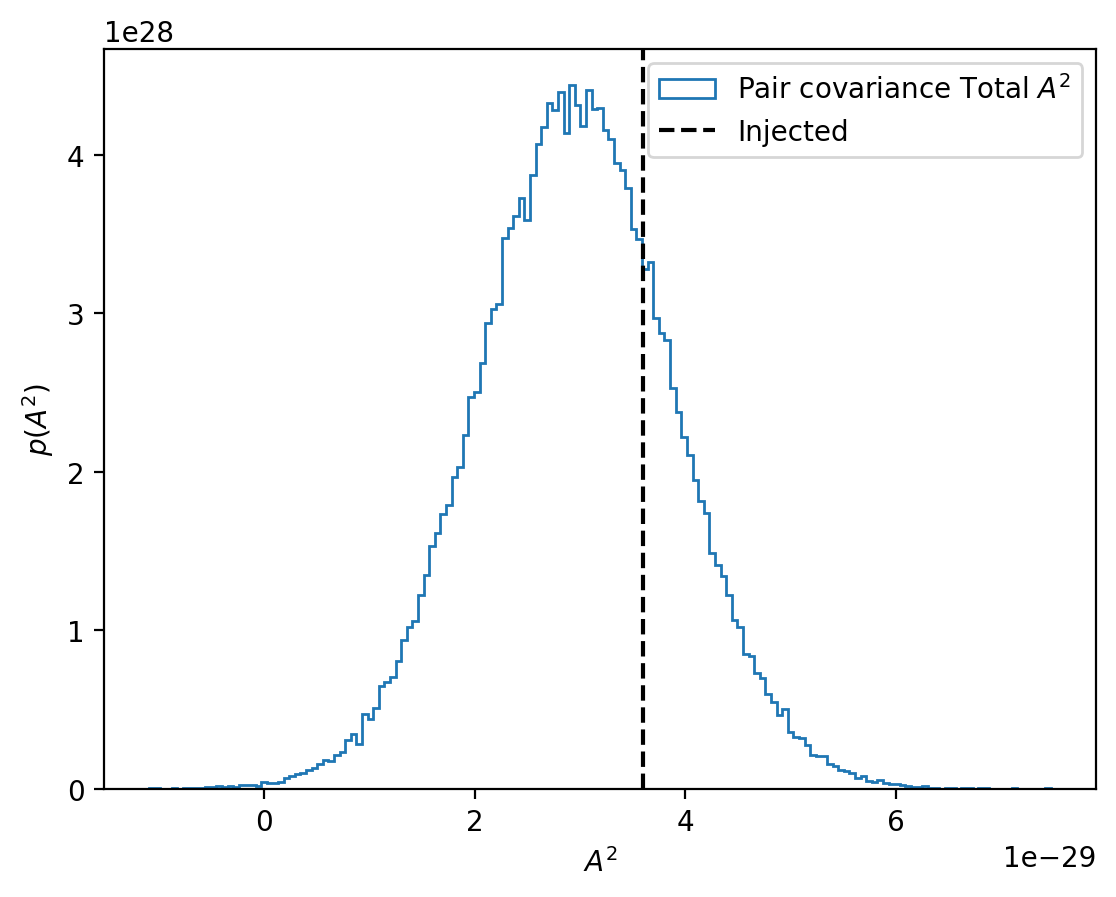

In [24]:
total_pc_a2 = uncertainty_sample(pc_nm_A2,pc_nm_A2s)

# Now plot the total distribution
plt.hist(total_pc_a2,bins='auto',histtype='step',density=True,label='Pair covariance Total $A^2$')


plt.axvline(true_amplitude**2,linestyle='dashed',color='k',label='Injected')
plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.legend()
plt.show()

Can you see the power of pair covariance now? The injected value is pretty easily in the distribution compared with the traditional NMOS. Do note however that this is true because we have a very strong signal. You can tell because the NMOS SNR distribution is insanely high (SNR of 9 is bonkers loud).


### Additional notes

The OS has a TON of extensions. This table (from [[Gersbach et al 2024](https://arxiv.org/pdf/2406.11954)]) shows just a small fraction of them:

![image](data/Images/OSnames_table.png)

What is also interesting is that all of these methods can work together to make a combined mostrosity of a name like:

**The Per-Frequency, Multi-Component, Pair-Covariant, Uncertainty Sampled, Noise-Marginalized Optimal Statistic, or PFMCPCUSNMOS for short** 

Yes, this is a real thing and it would allow you to estimate many correlation patterns' spectral shape simultaneously in a PTA in the strong signal regime. No, I have not tried running one of these, but you totally can if you find the need.

If you have questions about what the OS can do, or want to try encorporating the OS into your projects, let me know! I'd be happy to help!